In [1]:
import os
import sys
sys.path.append(os.path.join(os.getcwd(),".."))

import copy
import torch
import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from src.models.grace_module import GraceLitModule
from src.models.components.simple_dense_net import SimpleDenseNet

In [2]:
def min_max_scaler(arr, min_val, max_val):
    scaled_arr = 2 * (arr - min_val) / (max_val - min_val) - 1
    return scaled_arr

def preprocess_csv(data_dir, eye):
    # Read CSV
    files_path = os.path.join(os.getcwd(),"..",'data', data_dir, f"*{eye}*.csv")
    csv_files = glob.glob(files_path)
    
    dfs = []
    for csv_file in csv_files:
        temp_df = pd.read_csv(csv_file)
        dfs.append(temp_df)
    df = pd.concat(dfs, ignore_index=True)

    # Minmax Feature Scaler
    feature_ranges = {
        'x_c': (-3.0, 3.0),  # Original Range: (-2.0618, 2.0618)
        'y_c': (-3.0, 3.0),  # Original Range: (-1.1516, 1.1516)
        'z_c': (-3.0, 3.0),  # Original Range: (0.3, 3.0)
        'cmd_theta_lower_neck_pan': (-44, 44),
        'cmd_theta_lower_neck_tilt': (-44, 44),  # Original Range: (-13, 31)
        'cmd_theta_upper_neck_tilt': (-44, 44),  # Original Range: (-13, 44)
        'cmd_theta_left_eye': (-44, 44),
        'cmd_theta_right_eye': (-44, 44),
        'cmd_theta_tilt': (-44, 44),  # Original Range: (-31, 22)
    }

    # Filtered df
    filtered_df = df[~df.isin([-100.0]).any(axis=1)]
    filtered_df = filtered_df.reset_index(drop=True)

    # Create the scaled DataFrame
    scaled_df = filtered_df.copy()
    for col in filtered_df.columns[:8]:
        col_min, col_max = feature_ranges[col]
        scaled_df[col] = 2 * (filtered_df[col] - col_min) / (col_max - col_min) - 1

    return filtered_df, scaled_df

In [3]:
MAX_DEG_VALUE = 44
MAX_METER_VALUE = 3
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [4]:
filtered_df, scaled_df = preprocess_csv("20240715_032420_095729","left")

In [5]:
scaled_zero_df = scaled_df[(scaled_df['cmd_theta_lower_neck_pan']==0) & (scaled_df['cmd_theta_tilt']==0)].reset_index(drop=True)
scaled_zero_df

,x_c,y_c,z_c,cmd_theta_lower_neck_pan,cmd_theta_lower_neck_tilt,cmd_theta_upper_neck_tilt,cmd_theta_left_eye,cmd_theta_tilt,state_theta_lower_neck_pan,state_theta_left_lower_neck_tilt,state_theta_right_lower_neck_tilt,state_theta_left_upper_neck_tilt,state_theta_right_upper_neck_tilt,state_theta_left_eye,state_theta_tilt
0,-0.096995,-0.068861,0.346065,0.0,0.0,0.0,-0.318182,0.0,-0.439453,0.703125,-0.703125,-0.087891,0.087891,-13.974609,0.351562
1,-0.074933,-0.069088,0.345433,0.0,0.0,0.0,-0.272727,0.0,-0.439453,0.703125,-0.703125,-0.087891,0.087891,-11.953125,0.351562
2,-0.051882,-0.069524,0.344745,0.0,0.0,0.0,-0.227273,0.0,-0.439453,0.703125,-0.703125,-0.087891,0.087891,-10.019531,0.351562
3,-0.036601,-0.070030,0.344330,0.0,0.0,0.0,-0.181818,0.0,-0.439453,0.703125,-0.703125,-0.087891,0.087891,-8.085938,0.351562
4,-0.019619,-0.070391,0.343824,0.0,0.0,0.0,-0.136364,0.0,-0.439453,0.703125,-0.703125,-0.087891,0.087891,-6.152344,0.351562
5,-0.002211,-0.070967,0.343337,0.0,0.0,0.0,-0.090909,0.0,-0.439453,0.703125,-0.703125,-0.087891,0.087891,-4.042969,0.351562
6,0.015911,-0.071128,0.342794,0.0,0.0,0.0,-0.045455,0.0,-0.439453,0.703125,-0.703125,-0.087891,0.087891,-2.109375,0.351562
7,0.031195,-0.071358,0.342400,0.0,0.0,0.0,0.000000,0.0,-0.439453,0.703125,-0.703125,-0.087891,0.087891,-0.263672,0.351562
8,0.051594,-0.071455,0.341758,0.0,0.0,0.0,0.045455,0.0,-0.439453,0.703125,-0.703125,-0.087891,0.087891,1.757812,0.351562
9,0.068518,-0.071845,0.341287,0.0,0.0,0.0,0.090909,0.0,-0.439453,0.703125,-0.703125,-0.087891,0.087891,3.603516,0.351562


In [6]:
zero_df = filtered_df[(filtered_df['cmd_theta_lower_neck_pan']==0) & (filtered_df['cmd_theta_tilt']==0)].reset_index(drop=True)
zero_df

,x_c,y_c,z_c,cmd_theta_lower_neck_pan,cmd_theta_lower_neck_tilt,cmd_theta_upper_neck_tilt,cmd_theta_left_eye,cmd_theta_tilt,state_theta_lower_neck_pan,state_theta_left_lower_neck_tilt,state_theta_right_lower_neck_tilt,state_theta_left_upper_neck_tilt,state_theta_right_upper_neck_tilt,state_theta_left_eye,state_theta_tilt
0,-0.290985,-0.206584,1.038194,0,0,0,-14,0,-0.439453,0.703125,-0.703125,-0.087891,0.087891,-13.974609,0.351562
1,-0.224798,-0.207265,1.036298,0,0,0,-12,0,-0.439453,0.703125,-0.703125,-0.087891,0.087891,-11.953125,0.351562
2,-0.155646,-0.208573,1.034235,0,0,0,-10,0,-0.439453,0.703125,-0.703125,-0.087891,0.087891,-10.019531,0.351562
3,-0.109804,-0.210090,1.032990,0,0,0,-8,0,-0.439453,0.703125,-0.703125,-0.087891,0.087891,-8.085938,0.351562
4,-0.058856,-0.211174,1.031472,0,0,0,-6,0,-0.439453,0.703125,-0.703125,-0.087891,0.087891,-6.152344,0.351562
5,-0.006632,-0.212900,1.030010,0,0,0,-4,0,-0.439453,0.703125,-0.703125,-0.087891,0.087891,-4.042969,0.351562
6,0.047732,-0.213383,1.028383,0,0,0,-2,0,-0.439453,0.703125,-0.703125,-0.087891,0.087891,-2.109375,0.351562
7,0.093585,-0.214074,1.027201,0,0,0,0,0,-0.439453,0.703125,-0.703125,-0.087891,0.087891,-0.263672,0.351562
8,0.154783,-0.214364,1.025273,0,0,0,2,0,-0.439453,0.703125,-0.703125,-0.087891,0.087891,1.757812,0.351562
9,0.205553,-0.215535,1.023860,0,0,0,4,0,-0.439453,0.703125,-0.703125,-0.087891,0.087891,3.603516,0.351562


# (3,256)

In [7]:
ckpt_path = '/home/jaynieles/dev/grace_dl/logs/hidden_exp/multiruns/2024-07-25_23-49-51/14/checkpoints/epoch_403.ckpt'

In [8]:
model = GraceLitModule.load_from_checkpoint(ckpt_path)

/home/jaynieles/dev/aec/venv/lib/python3.8/site-packages/lightning/pytorch/utilities/parsing.py:208: Attribute 'net' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['net'])`.


# --

In [9]:
# Input

x = np.linspace(-0.3,0.5,100).reshape(-1,1)
y = np.array(len(x)*[-0.220595824629461]).reshape(-1,1)

In [10]:
# Standardization

norm_x = min_max_scaler(x, -MAX_METER_VALUE, MAX_METER_VALUE)
norm_y = min_max_scaler(y, -MAX_METER_VALUE, MAX_METER_VALUE)

In [11]:
# Preprocessing

padding = np.zeros((len(norm_x),4))
in_arr = np.concatenate((norm_x,norm_y,padding), axis=1)
in_arr.shape

(100, 6)

# Left Pan Cmd

In [12]:
# Input Tensor
zero_df = filtered_df[(filtered_df['cmd_theta_lower_neck_pan']==0) & (filtered_df['cmd_theta_tilt']==0)].reset_index(drop=True)
scaled_zero_df = scaled_df[(scaled_df['cmd_theta_lower_neck_pan']==0) & (scaled_df['cmd_theta_tilt']==0)].reset_index(drop=True)
in_tensor = torch.tensor(scaled_zero_df.iloc[:,:6].values, dtype=torch.float32).to(device)

In [13]:
model.eval()
# Output of DNN
with torch.no_grad():
    output = model(in_tensor)
    output = output.squeeze().cpu().numpy()
scaled_output = MAX_DEG_VALUE*output
scaled_output.shape

(15, 2)

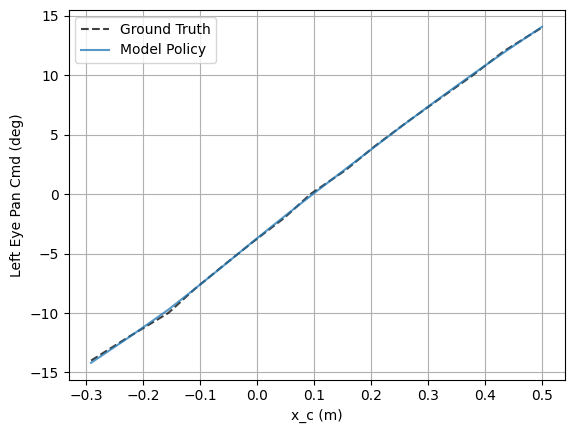

In [14]:
plt.plot(zero_df['x_c'], zero_df['cmd_theta_left_eye'], linestyle='--', alpha=0.75, color='black')
plt.plot(zero_df['x_c'], scaled_output[:,0], alpha=0.75)
plt.xlabel('x_c (m)')
plt.ylabel('Left Eye Pan Cmd (deg)')
plt.legend(['Ground Truth','Model Policy'])
plt.grid()

# Eyes Tilt

In [15]:
# Input Tensor
zero_df = filtered_df[(filtered_df['cmd_theta_lower_neck_pan']==0) & (filtered_df['cmd_theta_left_eye']==0)].reset_index(drop=True)
scaled_zero_df = scaled_df[(scaled_df['cmd_theta_lower_neck_pan']==0) & (scaled_df['cmd_theta_left_eye']==0)].reset_index(drop=True)
in_tensor = torch.tensor(scaled_zero_df.iloc[:,:6].values, dtype=torch.float32).to(device)

In [16]:
model.eval()
# Output of DNN
with torch.no_grad():
    output = model(in_tensor)
    output = output.squeeze().cpu().numpy()
scaled_output = MAX_DEG_VALUE*output
scaled_output.shape

(11, 2)

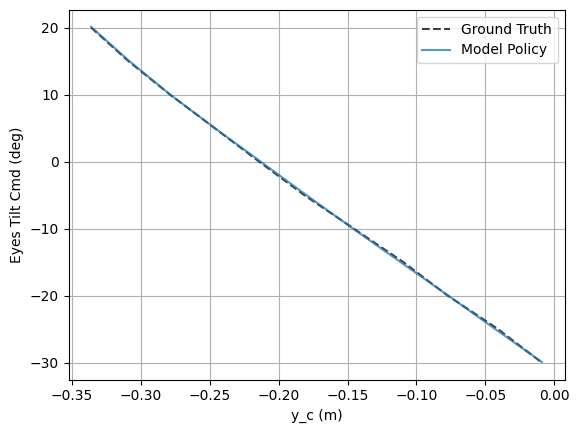

In [17]:
plt.plot(zero_df['y_c'], zero_df['cmd_theta_tilt'], linestyle='--', alpha=0.75, color='black')
plt.plot(zero_df['y_c'], scaled_output[:,1], alpha=0.75)
plt.xlabel('y_c (m)')
plt.ylabel('Eyes Tilt Cmd (deg)')
plt.legend(['Ground Truth','Model Policy'])
plt.grid()

# Multi Neck Rotation Policy (Pan)

In [18]:
def dnn_model(in_tensor):
    model.eval()
    with torch.no_grad():
        output = model(in_tensor)
        output = output.squeeze().cpu().numpy()
    scaled_output = MAX_DEG_VALUE*output
    return scaled_output

In [19]:
# Input 

zero_df = filtered_df[filtered_df['cmd_theta_tilt']==0].reset_index(drop=True)
scaled_zero_df = scaled_df[scaled_df['cmd_theta_tilt']==0].reset_index(drop=True)
in_tensor = torch.tensor(scaled_zero_df.iloc[:,:6].values, dtype=torch.float32).to(device)
scaled_output = dnn_model(in_tensor)
zero_df['dnn_left_eye_pan'] = scaled_output[:,0]
zero_df['dnn_eyes_tilt'] = scaled_output[:,1]

In [20]:
pan_rot = sorted(zero_df['cmd_theta_lower_neck_pan'].unique())
pan_rot

[-35, -30, -25, -20, -15, -10, -5, 0, 5, 10, 15, 20, 25, 30, 35]

In [21]:
policy_label = ['Model Policy (θ_lnp=%d°)' % x for x in pan_rot]
policy_label

['Model Policy (θ_lnp=-35°)',
 'Model Policy (θ_lnp=-30°)',
 'Model Policy (θ_lnp=-25°)',
 'Model Policy (θ_lnp=-20°)',
 'Model Policy (θ_lnp=-15°)',
 'Model Policy (θ_lnp=-10°)',
 'Model Policy (θ_lnp=-5°)',
 'Model Policy (θ_lnp=0°)',
 'Model Policy (θ_lnp=5°)',
 'Model Policy (θ_lnp=10°)',
 'Model Policy (θ_lnp=15°)',
 'Model Policy (θ_lnp=20°)',
 'Model Policy (θ_lnp=25°)',
 'Model Policy (θ_lnp=30°)',
 'Model Policy (θ_lnp=35°)']

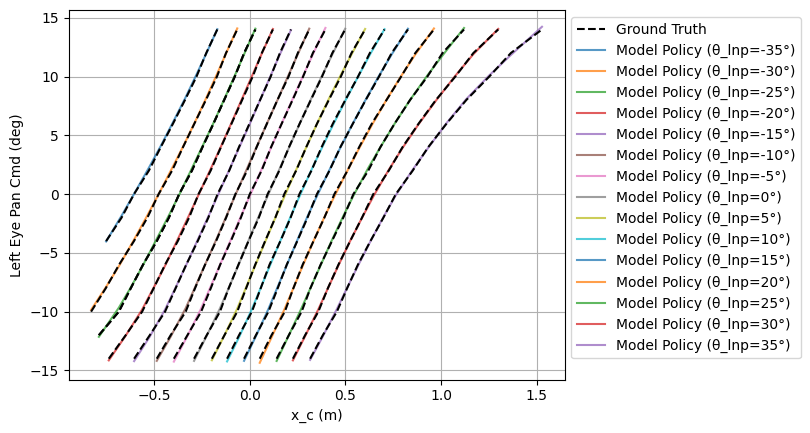

In [22]:
x = -25
plt.plot(zero_df[zero_df['cmd_theta_lower_neck_pan']==x]['x_c'], zero_df[zero_df['cmd_theta_lower_neck_pan']==x]['cmd_theta_left_eye'], linestyle='--', color='black')

for x in pan_rot:
    plt.plot(zero_df[zero_df['cmd_theta_lower_neck_pan']==x]['x_c'], zero_df[zero_df['cmd_theta_lower_neck_pan']==x]['dnn_left_eye_pan'], alpha=0.75)

for x in pan_rot:
    plt.plot(zero_df[zero_df['cmd_theta_lower_neck_pan']==x]['x_c'], zero_df[zero_df['cmd_theta_lower_neck_pan']==x]['cmd_theta_left_eye'], linestyle='--', color='black')

plt.xlabel('x_c (m)')
plt.ylabel('Left Eye Pan Cmd (deg)')
plt.legend(['Ground Truth']+policy_label, bbox_to_anchor=(1, 1))
plt.grid()

# Multi Neck Rotation Policy (Tilt)

In [23]:
# Input 

zero_df = filtered_df[filtered_df['cmd_theta_left_eye']==0].reset_index(drop=True)
scaled_zero_df = scaled_df[scaled_df['cmd_theta_left_eye']==0].reset_index(drop=True)
in_tensor = torch.tensor(scaled_zero_df.iloc[:,:6].values, dtype=torch.float32).to(device)
scaled_output = dnn_model(in_tensor)
zero_df['dnn_left_eye_pan'] = scaled_output[:,0]
zero_df['dnn_eyes_tilt'] = scaled_output[:,1]

In [24]:
pan_rot = zero_df['cmd_theta_lower_neck_pan'].unique()
pan_rot

array([-25,   0, -30,  20, -35, -15, -20,  30,  25,  -5,  10,   5,  35,
        15, -10])

In [25]:
policy_label = ['Model Policy (θ_lnp=%d°)' % x for x in pan_rot]
policy_label

['Model Policy (θ_lnp=-25°)',
 'Model Policy (θ_lnp=0°)',
 'Model Policy (θ_lnp=-30°)',
 'Model Policy (θ_lnp=20°)',
 'Model Policy (θ_lnp=-35°)',
 'Model Policy (θ_lnp=-15°)',
 'Model Policy (θ_lnp=-20°)',
 'Model Policy (θ_lnp=30°)',
 'Model Policy (θ_lnp=25°)',
 'Model Policy (θ_lnp=-5°)',
 'Model Policy (θ_lnp=10°)',
 'Model Policy (θ_lnp=5°)',
 'Model Policy (θ_lnp=35°)',
 'Model Policy (θ_lnp=15°)',
 'Model Policy (θ_lnp=-10°)']

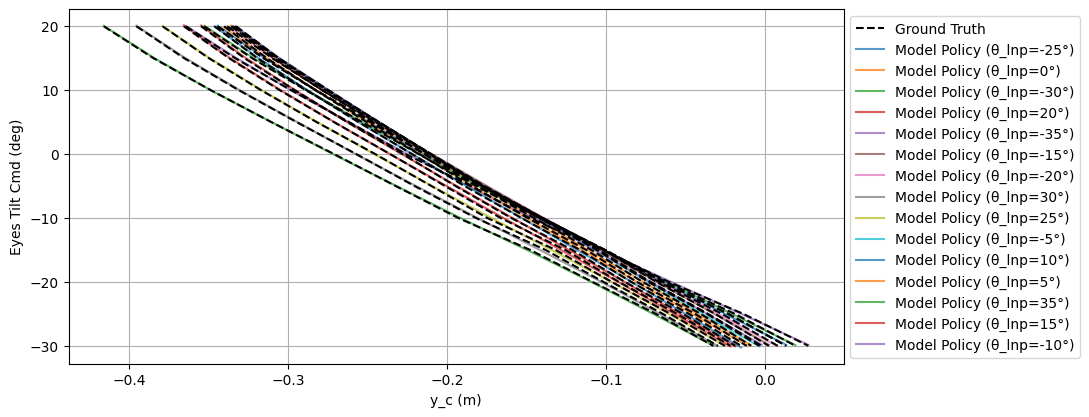

In [26]:
plt.figure(figsize=(10,4.6))
x = -25
plt.plot(zero_df[zero_df['cmd_theta_lower_neck_pan']==x]['y_c'], zero_df[zero_df['cmd_theta_lower_neck_pan']==x]['cmd_theta_tilt'], linestyle='--', color='black')

for x in pan_rot:
    plt.plot(zero_df[zero_df['cmd_theta_lower_neck_pan']==x]['y_c'], zero_df[zero_df['cmd_theta_lower_neck_pan']==x]['dnn_eyes_tilt'], alpha=0.75)

for x in pan_rot:
    plt.plot(zero_df[zero_df['cmd_theta_lower_neck_pan']==x]['y_c'], zero_df[zero_df['cmd_theta_lower_neck_pan']==x]['cmd_theta_tilt'], linestyle='--', color='black')

plt.xlabel('y_c (m)')
plt.ylabel('Eyes Tilt Cmd (deg)')
plt.legend(['Ground Truth']+policy_label, bbox_to_anchor=(1, 1))
plt.grid()